In [ ]:
# Идея: собрать вместе наборы данных и выделить сессии, которые можно считать аномальными
# Далее на аномальных сессиях запустить классификатор

In [1]:
from collections import defaultdict, Counter
from datetime import datetime

import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import numpy as np
import math


DATASET_VERSION = '3.2'
DATA_PATH = f'../data/r{DATASET_VERSION}/{{type}}.csv'
ANSWERS_PATH = f'../data/answers/r{DATASET_VERSION}-{{attacker}}.csv'
DATE_FORMAT = '%Y-%m-%dT%H:%M:%S'

In [2]:
def dt(timestamp: str) -> datetime:
    return datetime.strptime(timestamp, '%m/%d/%Y %H:%M:%S')

In [3]:
# Шаги:
# 1. Взять logon.csv и получить ID, время начлаа и конца всех сессий.
# 2. Взять среднее время первого входа и последнего выхода каждого сотрудника за первые три месяца, чтобы получить продолжительность рабочего дня
# 3. Добавить к данным о сессиях, в рабочее время они происходили или нет (не в рабочее – если сессия закначивалась до начала рабочего дня или начаналась после)
# 4. Склеить действия из device и file, проставить сессии и рабочее / нерабочее время
# 5. Получить агрегатные данные по сессиям (сколько раз подключалось устройство, сколько было открыто файлов)
# 6. За первые штри месяца посчитать средние и отклонения от них в процентах (0..1)
# 7. Запустить OCSVM на сессиях каждого пользователя и выбрать аномальные сессии
# 8. Отфильтровать данные по аномальным сессиям

In [4]:
logon_df = pd.read_csv(DATA_PATH.format(type='logon'))

In [5]:
logon_df.head()

,id,date,user,pc,activity
0,{Q9R3-U1PE27LQ-2164BJLT},01/01/2010 06:20:00,SLW0616,PC-0110,Logon
1,{R1B6-S0LQ34EP-3361QPTV},01/01/2010 06:28:00,RPM0600,PC-9164,Logon
2,{Y3R9-H0JY37RA-5902HXNX},01/01/2010 07:04:00,DAM0170,PC-1525,Logon
3,{D5B1-I6BP26NF-3845HZNZ},01/01/2010 07:23:00,WXW0044,PC-9422,Logon
4,{I0N6-I9PB69SZ-5272SLAT},01/01/2010 07:31:00,RLD0349,PC-1290,Logon


In [6]:
sessions = defaultdict(list)

for _, row in logon_df.iterrows():
    user = row['user']
    ts = dt(row['date'])
    action = row['activity']

    if action == 'Logon':
        if sessions[user] and len(sessions[user][-1]) == 1:
            sessions[user][-1] = (sessions[user][-1][0], ts)
        sessions[user].append((ts,))
    else:
        if sessions[user] and len(sessions[user][-1]) == 2:
            sessions[user].append((None, ts))
        else:
            sessions[user][-1] = (sessions[user][-1][0], ts)



In [ ]:
actions_df = pd.concat(
    [
        logon_df,
        pd.read_csv(DATA_PATH.format(type='file')),
        pd.read_csv(DATA_PATH.format(type='device')),
    ],
    axis=0,
    ignore_index=True,
)

In [ ]:
actions_df['timestamp'] = actions_df.apply(lambda x: dt(x['date']).strftime('%Y-%m-%dT%H:%M:%S'), axis=1)

In [ ]:
actions_df = actions_df.sort_values(by='timestamp')

In [ ]:
def get_session_id(user: str, timestamp: datetime) -> str:
    for idx, (from_, to_) in enumerate(sessions[user]):
        if from_ is not None and (from_ <= timestamp <= to_):
            return f'{user}_{idx}'
        if from_ is None and to_ > timestamp:
            return f'{user}_{idx}'

actions_df['session_id'] = actions_df.apply(lambda x: get_session_id(x['user'], dt(x['date'])), axis=1)

In [ ]:
actions_df['filename'] = actions_df['filename'].fillna('')

actions_df['file_activity'] = actions_df.apply(lambda x: int(bool(x['filename'])), axis=1)
actions_df['device_activity'] = actions_df.apply(lambda x: int(x['activity'] in {'Connect', 'Disconnect'}), axis=1)

In [ ]:
actions_df.head()

,id,date,user,pc,activity,filename,content,timestamp,session_id,file_activity,device_activity
0,{Q9R3-U1PE27LQ-2164BJLT},01/01/2010 06:20:00,SLW0616,PC-0110,Logon,,NaN,2010-01-01T06:20:00,SLW0616_0,0,0
1,{R1B6-S0LQ34EP-3361QPTV},01/01/2010 06:28:00,RPM0600,PC-9164,Logon,,NaN,2010-01-01T06:28:00,RPM0600_0,0,0
1280120,{R8N4-R8YE70QN-3287FCGL},01/01/2010 06:46:40,RPM0600,PC-9164,Connect,,NaN,2010-01-01T06:46:40,RPM0600_0,0,1
845351,{M8R9-I5RI11PG-5467DBVR},01/01/2010 06:51:00,RPM0600,PC-9164,NaN,5B9VCBIU.doc,D0-CF-11-E0-A1-B1-1A-E1 m45 adss arxiv 1128955...,2010-01-01T06:51:00,RPM0600_0,1,0
2,{Y3R9-H0JY37RA-5902HXNX},01/01/2010 07:04:00,DAM0170,PC-1525,Logon,,NaN,2010-01-01T07:04:00,DAM0170_0,0,0


In [ ]:
sessions_df = actions_df.groupby(['user', 'session_id']).agg({'timestamp': ['min', 'max'], 'file_activity': ['sum', 'max'], 'device_activity': ['sum', 'max']}).reset_index()

In [ ]:
sessions_df.columns = ['user', 'session_id', 'session_start', 'session_end', 'file_activity', 'file_activity_bool', 'device_activity', 'device_activity_bool']

In [ ]:
sessions_df.head()

,user,session_id,session_start,session_end,file_activity,file_activity_bool,device_activity,device_activity_bool
0,AAB0754,AAB0754_0,2010-01-04T09:05:00,2010-01-04T13:37:13,0,0,0,0
1,AAB0754,AAB0754_1,2010-01-04T20:02:00,2010-01-04T20:02:00,0,0,0,0
2,AAB0754,AAB0754_10,2010-01-12T09:07:00,2010-01-12T14:41:37,0,0,0,0
3,AAB0754,AAB0754_100,2010-03-17T08:50:00,2010-03-17T13:58:22,0,0,0,0
4,AAB0754,AAB0754_101,2010-03-17T20:04:00,2010-03-17T20:04:00,0,0,0,0


In [ ]:
def timestamp_to_minutes(timestamp: datetime) -> int:
    return (timestamp.hour * 60 + timestamp.minute) / (60 * 24)

sessions_df['session_start_rlt'] = sessions_df.apply(
    lambda x: timestamp_to_minutes(datetime.strptime(x['session_start'], DATE_FORMAT)),
    axis=1,
)
sessions_df['session_end_rlt'] = sessions_df.apply(
    lambda x: timestamp_to_minutes(datetime.strptime(x['session_end'], DATE_FORMAT)),
    axis=1,
)

sessions_df.head()

,user,session_id,session_start,session_end,file_activity,file_activity_bool,device_activity,device_activity_bool,session_start_rlt,session_end_rlt
0,AAB0754,AAB0754_0,2010-01-04T09:05:00,2010-01-04T13:37:13,0,0,0,0,0.378472,0.567361
1,AAB0754,AAB0754_1,2010-01-04T20:02:00,2010-01-04T20:02:00,0,0,0,0,0.834722,0.834722
2,AAB0754,AAB0754_10,2010-01-12T09:07:00,2010-01-12T14:41:37,0,0,0,0,0.379861,0.611806
3,AAB0754,AAB0754_100,2010-03-17T08:50:00,2010-03-17T13:58:22,0,0,0,0,0.368056,0.581944
4,AAB0754,AAB0754_101,2010-03-17T20:04:00,2010-03-17T20:04:00,0,0,0,0,0.836111,0.836111


In [ ]:
user_to_sessions = {
    user: sessions_df[sessions_df['user'] == user]
    for user in set(sessions_df['user'])
}

In [ ]:
# user_to_sessions['AAC0070']

In [ ]:
def draw_anomalies_session_time(data, anomalies):
    plt.figure(figsize=(10, 7))
    # Точки, предсказанные как обычные
    plt.scatter(data[anomalies == 1]['session_start_rlt'], data[anomalies == 1]['session_end_rlt'], c='blue', alpha=0.2, label='Обычные точки')
    # Точки, предсказанные как аномалии
    plt.scatter(data[anomalies == -1]['session_start_rlt'], data[anomalies == -1]['session_end_rlt'], c='red', alpha=0.2, label='Аномалии')
    plt.legend()
    plt.xlabel('Logon')
    plt.ylabel('Logoff')
    plt.title('Результаты поиска аномалий')
    plt.show()

In [ ]:
# user_to_sessions['AAC0070'].columns

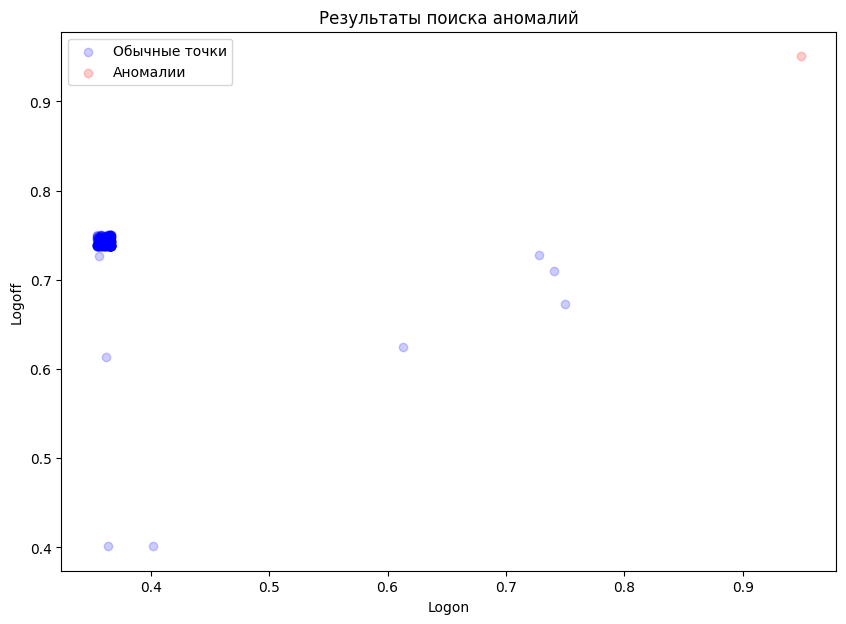

Counter({1: 428, -1: 1})

In [ ]:
from sklearn.cluster import DBSCAN

def time_metric(X, Y):
    a = min(abs(Y[0] - X[0]),abs(X[0] + 1 - Y[0]))
    b = min(abs(Y[1] - X[1]),abs(X[1] + 1 - Y[1]))
    return (a * a + b * b) ** 0.5

sessions3 = user_to_sessions['SSD0484']
df = sessions3.drop(
    ['user', 'session_id', 'session_start', 'session_end', 'file_activity',
       'file_activity_bool', 'device_activity', 'device_activity_bool'],
    axis=1,
)

db = DBSCAN(eps=0.3, min_samples=7, metric=time_metric).fit(df)

draw_anomalies_session_time(df, np.array([-1 if i == -1 else 1 for i in db.labels_]))
Counter([-1 if i == -1 else 1 for i in db.labels_])

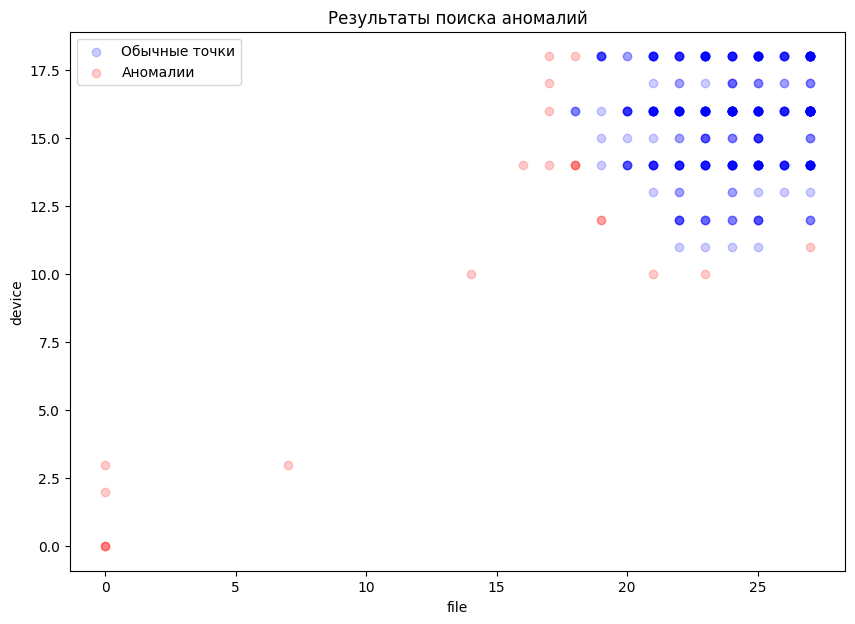

In [ ]:
df = user_to_sessions['SSD0484'].drop(
    ['user', 'session_id', 'session_start', 'session_end', 'file_activity_bool',
        'device_activity_bool',
       'session_start_rlt', 'session_end_rlt'],
    axis=1,
)


db = DBSCAN(eps=1, min_samples=30, metric=time_metric).fit(df)

anomalies = np.array([-1 if i == -1 else 1 for i in db.labels_])
plt.figure(figsize=(10, 7))
# Точки, предсказанные как обычные
plt.scatter(df[anomalies == 1]['file_activity'], df[anomalies == 1]['device_activity'], c='blue', alpha=0.2, label='Обычные точки')
# Точки, предсказанные как аномалии
plt.scatter(df[anomalies == -1]['file_activity'], df[anomalies == -1]['device_activity'], c='red', alpha=0.2, label='Аномалии')
plt.legend()
plt.xlabel('file')
plt.ylabel('device')
plt.title('Результаты поиска аномалий')
plt.show()

In [ ]:
# используем DBSCAN
malicios_sessions = set()
for user, user_sessions_df in user_to_sessions.items():
    df = user_sessions_df.drop(
        ['user', 'session_id', 'session_start', 'session_end', 'file_activity',
       'file_activity_bool', 'device_activity', 'device_activity_bool'],
        axis=1,
    )
    db = DBSCAN(eps=0.3, min_samples=7, metric=time_metric).fit(df)

    for session_id, pred in zip(user_sessions_df['session_id'], db.labels_):
        if pred == -1:
            malicios_sessions.add(session_id)

In [ ]:
# используем DBSCAN
malicios_sessions1 = set()
for user, user_sessions_df in user_to_sessions.items():
    df = user_sessions_df.drop(
        ['user', 'session_id', 'session_start', 'session_end', 'file_activity',
        'device_activity',
       'session_start_rlt', 'session_end_rlt'],
        axis=1,
    )
    db = DBSCAN(eps=0.5, min_samples=7).fit(df)

    for session_id, pred in zip(user_sessions_df['session_id'], db.labels_):
        if pred == -1:
            malicios_sessions1.add(session_id)

In [ ]:
malicios_sessions1 & malicios_sessions

{'RCW0822_189',
 'RCW0822_192',
 'RCW0822_196',
 'RCW0822_198',
 'RCW0822_204',
 'SSD0484_369'}

In [ ]:
train_period_until = ''

In [55]:
filtered_sessions_df = sessions_df[sessions_df.apply(lambda x: x['session_id'] in malicios_sessions, axis=1)]

In [56]:
filtered_sessions_df.head()

,user,session_id,session_start,session_end,file_activity,device_activity,session_start_rlt,session_end_rlt
1362,AAR0716,AAR0716_292,2010-08-16T18:33:33,2010-08-16T19:07:11,0,0,0.772917,0.796528
1599,AAR0716,AAR0716_505,2011-02-03T17:31:29,2011-02-03T17:41:06,0,0,0.729861,0.736806
3514,ABH0821,ABH0821_125,2010-03-22T16:29:00,2010-03-29T15:24:17,1,0,0.686806,0.641667
3639,ABH0821,ABH0821_238,2010-06-24T18:17:57,2010-06-25T03:11:26,1,1,0.761806,0.132639
3708,ABH0821,ABH0821_30,2010-01-22T10:49:05,2010-01-22T11:40:57,1,1,0.450694,0.486111


In [30]:
set(filtered_sessions_df['user'])

NameError: name 'filtered_sessions_df' is not defined

In [60]:
target_ids = set()

with open(ANSWERS_PATH.format(attacker=1)) as f1:
    for row in f1.readlines():
        if row.strip():
            target_ids.add(row.split(',')[1])

In [61]:
insider_session_ids = set()

for _, row in actions_df.iterrows():
    if str(row['id']) in target_ids:
        insider_session_ids.add(row['session_id'])

In [62]:
insider_session_ids <= malicios_sessions  # инсайдерские сессии есть в выбранных нами?

True

In [63]:
# для инсайдера CSF0929 все сессии еть
# для инсайдера CCH0959 нет, потому что многие из них состоят исключительно из http запросов,
# которые на данный момент мы не обрабатывали – сейчас мы его игнорируем

for sid in insider_session_ids:
    print(sid, sid in malicios_sessions)

CSF0929_141 True
CSF0929_138 True
CSF0929_126 True
CSF0929_129 True
CSF0929_134 True
CSF0929_132 True


In [64]:
filtered_actions_df = actions_df[actions_df.apply(lambda x: x['session_id'] in malicios_sessions, axis=1)]

In [65]:
filtered_actions_df['target'] = filtered_actions_df.apply(lambda x: x['id'] in target_ids, axis=1)

/tmp/ipykernel_7371/1027974661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_actions_df['target'] = filtered_actions_df.apply(lambda x: x['id'] in target_ids, axis=1)


In [89]:
# баланс?
filtered_actions_df[filtered_actions_df['target'] == 1].shape[0] / filtered_actions_df.shape[0]

0.0038475411807142

In [42]:
filtered_actions_df.columns

Index(['id', 'date', 'user', 'pc', 'activity', 'filename', 'content',
       'timestamp', 'session_id', 'file_activity', 'device_activity',
       'target'],
      dtype='object')

In [43]:
sessions_df.to_csv('../datasets/r3.1-session_df.csv')

In [88]:
filtered_actions_df.to_csv('../datasets/r3.1-actions_df_1.csv')

In [90]:
len(target_ids)

35